In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['all.zip', 'train_metadata', 'breed_labels.csv', 'color_labels.csv', 'train_images', 'test', 'test_sentiment', 'test_images', 'train', 'train_sentiment', 'test_metadata', 'state_labels.csv']


In [22]:
print(os.listdir("../input/train"))
#print(os.listdir("../input/train_images"))

['train.csv']


> # Exploring the Data

## Checking the available data

In [23]:
df_train = pd.read_csv("../input/train/train.csv")
df_train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [24]:
df_train.head().loc[2, 'Description']

'Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.'

In [25]:
df_test = pd.read_csv("../input/test/test.csv")

In [26]:
print(f"training: {len(df_train)} \t testing: {len(df_test)}")

training: 14993 	 testing: 3948


In [27]:
import json

In [28]:
with open("../input/train_sentiment/df880995b.json") as f:
    json_sample = json.load(f)

In [29]:
json_sample

{'sentences': [{'text': {'content': 'Brownie is just the cutest little boy with his sharp snout and his pointed ears.',
    'beginOffset': -1},
   'sentiment': {'magnitude': 0.7, 'score': 0.7}},
  {'text': {'content': 'Looks like a little bull dog.', 'beginOffset': -1},
   'sentiment': {'magnitude': 0.3, 'score': -0.3}},
  {'text': {'content': 'Alert to sounds and loves to play and easily trained.',
    'beginOffset': -1},
   'sentiment': {'magnitude': 0.9, 'score': 0.9}},
  {'text': {'content': 'Please contact Elaine at the second number for immediate response.',
    'beginOffset': -1},
   'sentiment': {'magnitude': 0, 'score': 0}}],
 'tokens': [],
 'entities': [{'name': 'boy',
   'type': 'PERSON',
   'metadata': {},
   'salience': 0.48413265,
   'mentions': [{'text': {'content': 'boy', 'beginOffset': -1},
     'type': 'COMMON'}]},
  {'name': 'Brownie',
   'type': 'OTHER',
   'metadata': {},
   'salience': 0.23412347,
   'mentions': [{'text': {'content': 'Brownie', 'beginOffset': -1},

In [30]:
df_train.describe(include='all')

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
count,14993.000000,13736,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,...,14993.000000,14993.000000,14993.000000,14993.000000,14993,14993.000000,14981,14993,14993.000000,14993.000000
unique,NaN,9060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5595,NaN,14032,14993,NaN,NaN
top,NaN,Baby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,fa90fa5b1ee11c86938398b60abc32cb,NaN,For Adoption,6ad5153bb,NaN,NaN
freq,NaN,66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,459,NaN,164,1,NaN,NaN
mean,1.457614,NaN,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,...,1.036617,1.576069,21.259988,41346.028347,NaN,0.056760,NaN,NaN,3.889215,2.516441
std,0.498217,NaN,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,...,0.199535,1.472477,78.414548,32.444153,NaN,0.346185,NaN,NaN,3.487810,1.177265
min,1.000000,NaN,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,41324.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000
25%,1.000000,NaN,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,...,1.000000,1.000000,0.000000,41326.000000,NaN,0.000000,NaN,NaN,2.000000,2.000000
50%,1.000000,NaN,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,1.000000,1.000000,0.000000,41326.000000,NaN,0.000000,NaN,NaN,3.000000,2.000000
75%,2.000000,NaN,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,...,1.000000,1.000000,0.000000,41401.000000,NaN,0.000000,NaN,NaN,5.000000,4.000000


In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

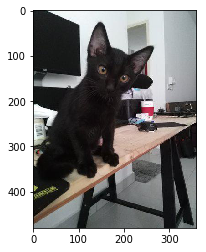

In [32]:
from pylab import imread,subplot,imshow,show
import matplotlib.pyplot as plt
image = imread('../input/train_images/86e1089a3-1.jpg') 
plt.imshow(image)


In [33]:
pd.read_csv('../input/color_labels.csv')

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream
5,6,Gray
6,7,White


### Notes
* **Breeds, Colors, State** need changing to categories
* **PhotoAmt** could do with changing to an integer
* Missing **Description** need replacing with "none" or "N/A", if used in model
* Explore descriptions in greater depth
* Missing **Name** need replacing with "none" or "N/A", if used in model
* Need to ensure model is suitable for categorical output: classifiers, logistic regression etc
* Categories for **Fur Length**, **Vaccinated** **etc**
* One-Hot Encoding for categories
* Looking at top rows, RescuerID can be the same many times - I suspect this is a pet shelter


## Analysing Description

In [34]:
df_sample = df_train.head(20)

In [35]:
df_sample

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2
5,2,NaN,3,266,0,2,5,6,0,2,...,1,1,0,41326,22fe332bf9c924d4718005891c63fbed,0,This is a stray kitten that came to my house. ...,d24c30b4b,2.0,2
6,2,BULAT,12,264,264,1,1,0,0,2,...,1,1,300,41326,1e0b5a458b5b77f5af581d57ebf570b3,0,anyone within the area of ipoh or taiping who ...,1caa6fcdb,3.0,1
7,1,Siu Pak & Her 6 Puppies,0,307,0,2,1,2,7,2,...,1,6,0,41326,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies...,97aa9eeac,9.0,3
8,2,NaN,2,265,0,2,6,0,0,2,...,1,1,0,41326,d8af7afece71334473575c9f70daf00d,0,"healthy and active, feisty kitten found in nei...",c06d167ca,6.0,1
9,2,Kitty,12,265,0,2,1,7,0,2,...,1,1,0,41326,1f3f36e4b18e94855b3e88af0852fdc4,0,"Very manja and gentle stray cat found, we woul...",7a0942d61,2.0,4


In [36]:
from collections import Counter, defaultdict
import string
from nltk.corpus import stopwords

In [37]:
remove_punc = str.maketrans({key: None for key in string.punctuation})
stopwords = set(stopwords.words('english'))

In [38]:
def bag_of_words(df, include=None, exclude=[]):
    dct = defaultdict(Counter)
    for i, speed, desc in df[['AdoptionSpeed','Description']].itertuples():
        try:
            desc = desc.translate(remove_punc).lower()
        except AttributeError:
            continue
        for word in desc.split():
            if (include == None or word in include) and word not in exclude:
                dct[speed][word] += 1
    return dct
    

In [39]:
BoW = bag_of_words(df_train, exclude=stopwords)

In [40]:
BoW[0].most_common(50)

[('home', 172),
 ('please', 135),
 ('cat', 126),
 ('kitten', 98),
 ('adoption', 91),
 ('care', 86),
 ('adopt', 85),
 ('love', 81),
 ('2', 76),
 ('looking', 75),
 ('new', 75),
 ('dog', 73),
 ('good', 73),
 ('found', 71),
 ('kittens', 70),
 ('adopted', 66),
 ('take', 65),
 ('owner', 65),
 ('playful', 64),
 ('interested', 62),
 ('contact', 61),
 ('healthy', 59),
 ('give', 57),
 ('3', 57),
 ('active', 56),
 ('call', 56),
 ('old', 56),
 ('cats', 56),
 ('would', 55),
 ('puppy', 54),
 ('one', 51),
 ('like', 49),
 ('loving', 49),
 ('keep', 48),
 ('also', 47),
 ('need', 47),
 ('food', 47),
 ('1', 46),
 ('adopter', 45),
 ('time', 44),
 ('must', 44),
 ('little', 43),
 ('kucing', 42),
 ('find', 41),
 ('someone', 41),
 ('play', 41),
 ('loves', 41),
 ('female', 39),
 ('dan', 39),
 ('4', 38)]

In [41]:
all_words = set()
exclude = set()
for speed in range(5):
    freq = BoW[speed].most_common()
    for word,_ in freq:
        if word in all_words:
            exclude.add(word)
        all_words.add(word)
include = all_words - exclude
        

In [42]:
include

{'soy',
 'godo',
 'cousins',
 'misunderstanded',
 'tuula',
 'birth23am',
 'loveif',
 'onthank',
 'majusetapakdanau',
 'pokerface',
 'kittybut',
 'itonly',
 'indoorsas',
 'kluang',
 'ream',
 'patatoes',
 'sadi',
 'kasawari',
 'sometimeshe',
 '嗨，我是小王子！',
 'oldso',
 'melakahe',
 'shaky',
 'wart',
 '‘nopetsallowed’',
 'inez',
 'contributiondonation',
 'bersandar',
 'postwalk',
 'secepatcepatnya',
 'mute',
 'kindest',
 'itnow',
 'togel',
 'lighting',
 'mpsprefer',
 'lena',
 'teentin',
 'toooo',
 'mice',
 'nutripet',
 'melacca',
 'longkag',
 'rightwell',
 'themcouple',
 'aadopt',
 'romantic',
 'riley',
 'awaynow',
 'dimandulkansesuai',
 'attacthed',
 '性格比较害怕人，只可以养在室内，要有养猫经验，要有耐心和他接触。',
 '2make',
 'ipohlumut',
 'healthywith',
 'kesejukan',
 'soot',
 'areaneed',
 'cagehe',
 'tehres',
 'housecat',
 'upnow',
 'threatens',
 'itbut',
 'catskittendog',
 'organic',
 'terdengar',
 'pistachio',
 'loser',
 'moreshe',
 'chubbythey',
 'thereplease',
 'kerjahari',
 'boiboi',
 'apartmenttaman',
 'reall',
 

In [43]:
df_train_speed0 = df_train[df_train['AdoptionSpeed'] == 0]

In [44]:
BoW = bag_of_words(df_train)

In [45]:
BoW[4].most_common()

[('and', 8258),
 ('to', 7741),
 ('a', 6757),
 ('is', 4885),
 ('the', 4765),
 ('for', 3684),
 ('i', 3285),
 ('her', 3138),
 ('she', 3008),
 ('of', 2812),
 ('in', 2332),
 ('very', 2180),
 ('home', 2075),
 ('are', 2054),
 ('with', 1997),
 ('he', 1940),
 ('you', 1870),
 ('be', 1683),
 ('my', 1493),
 ('please', 1481),
 ('them', 1480),
 ('at', 1478),
 ('dog', 1444),
 ('we', 1418),
 ('me', 1405),
 ('have', 1398),
 ('will', 1375),
 ('as', 1370),
 ('if', 1345),
 ('was', 1319),
 ('him', 1265),
 ('they', 1246),
 ('can', 1194),
 ('this', 1179),
 ('but', 1149),
 ('good', 1061),
 ('not', 1061),
 ('cat', 1050),
 ('or', 980),
 ('on', 980),
 ('that', 938),
 ('by', 937),
 ('has', 913),
 ('adoption', 886),
 ('adopt', 849),
 ('give', 831),
 ('so', 818),
 ('it', 816),
 ('loving', 802),
 ('from', 783),
 ('contact', 734),
 ('now', 722),
 ('his', 721),
 ('love', 719),
 ('looking', 704),
 ('2', 696),
 ('all', 688),
 ('friendly', 677),
 ('when', 670),
 ('care', 667),
 ('found', 662),
 ('dogs', 641),
 ('who', 63

In [46]:
model_words = set()
for k,v in BoW.items():
    freq = v.most_common(100)
    for word,_ in freq:
        model_words.add(word)
len(model_words)
    

116

In [47]:
model_words

{'1',
 '2',
 '3',
 'a',
 'active',
 'adopt',
 'adopted',
 'adopter',
 'adoption',
 'all',
 'also',
 'am',
 'an',
 'and',
 'are',
 'around',
 'as',
 'at',
 'be',
 'been',
 'but',
 'by',
 'call',
 'can',
 'care',
 'cat',
 'cats',
 'contact',
 'cute',
 'do',
 'dog',
 'dogs',
 'family',
 'female',
 'find',
 'food',
 'for',
 'found',
 'friendly',
 'from',
 'give',
 'good',
 'has',
 'have',
 'he',
 'healthy',
 'her',
 'him',
 'his',
 'home',
 'house',
 'i',
 'if',
 'in',
 'interested',
 'is',
 'it',
 'just',
 'keep',
 'kitten',
 'kittens',
 'kucing',
 'like',
 'little',
 'looking',
 'love',
 'loves',
 'loving',
 'me',
 'months',
 'must',
 'my',
 'need',
 'new',
 'no',
 'not',
 'now',
 'of',
 'old',
 'on',
 'one',
 'only',
 'or',
 'other',
 'our',
 'owner',
 'playful',
 'please',
 'puppies',
 'puppy',
 'rescued',
 'she',
 'so',
 'someone',
 'take',
 'that',
 'the',
 'their',
 'them',
 'there',
 'they',
 'this',
 'time',
 'to',
 'up',
 'us',
 'very',
 'was',
 'we',
 'when',
 'who',
 'will',
 '

In [48]:
df_train_desc = df_train[['PetID','Description', 'AdoptionSpeed']].copy()
#df_test_desc = df_test[['PetID', 'Description']].copy()

In [49]:
def apply_word_flags(df, words):
    for word in words:
        df[word] = 0
    for i, desc in df['Description'].items():
        try:
            for word in desc.split():
                if word in words:
                    df.at[i,word] = 1
        except AttributeError:
            continue
    return df

In [50]:
df_train_words = apply_word_flags(df_train_desc, model_words)
#df_test_words = apply_word_flags(df_test_desc, model_words)

In [51]:
df_train_words.head()

,PetID,Description,AdoptionSpeed,must,2,they,no,us,female,puppy,...,your,someone,food,puppies,from,adopted,just,her,them,you
0,86e1089a3,Nibble is a 3+ month old ball of cuteness. He ...,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,6296e909a,I just found it alone yesterday near my apartm...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3422e4906,Their pregnant mother was dumped by her irresp...,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,5842f1ff5,"Good guard dog, very alert, active, obedience ...",2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,850a43f90,This handsome yet cute boy is up for adoption....,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [52]:
from sklearn.ensemble import RandomForestClassifier

/home/rich/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [53]:
X_train_all = df_train_words.drop(columns=['PetID','AdoptionSpeed','Description'])
y_train_all = df_train_words['AdoptionSpeed']
# X_test = df_test_words.drop(columns=['PetID', 'Description'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_all, y_train_all, test_size=0.20).copy()

In [54]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.3581193731243748

In [55]:
prediction = rfc.predict(X_test)

In [57]:
import ml_metrics

In [58]:
ml_metrics.quadratic_weighted_kappa(rater_a=prediction, rater_b=y_test)

0.15852210126012944

In [59]:
feature_importance = rfc.feature_importances_
word_importance = []
for i,word in enumerate(feature_importance):
    word_importance.append((word, X_train.columns[i]))
    
    

In [60]:
model_words = set()
for score, word in sorted(word_importance, reverse=True):
    if score >= 0.005:
        model_words.add(word)
    else:
        break
model_words

{'1',
 '2',
 '3',
 'a',
 'active',
 'adopt',
 'adopted',
 'adopter',
 'adoption',
 'all',
 'also',
 'an',
 'and',
 'are',
 'around',
 'as',
 'at',
 'be',
 'been',
 'but',
 'by',
 'call',
 'can',
 'care',
 'cat',
 'cats',
 'contact',
 'cute',
 'do',
 'dog',
 'family',
 'female',
 'find',
 'food',
 'for',
 'found',
 'friendly',
 'from',
 'give',
 'good',
 'has',
 'have',
 'he',
 'healthy',
 'her',
 'him',
 'his',
 'home',
 'house',
 'i',
 'if',
 'in',
 'interested',
 'is',
 'it',
 'just',
 'keep',
 'kitten',
 'kittens',
 'like',
 'little',
 'looking',
 'love',
 'loves',
 'loving',
 'me',
 'months',
 'must',
 'my',
 'need',
 'new',
 'no',
 'not',
 'now',
 'of',
 'old',
 'on',
 'one',
 'only',
 'or',
 'other',
 'owner',
 'playful',
 'please',
 'puppies',
 'puppy',
 'rescued',
 'she',
 'so',
 'take',
 'that',
 'the',
 'their',
 'them',
 'they',
 'this',
 'time',
 'to',
 'up',
 'very',
 'was',
 'we',
 'when',
 'who',
 'will',
 'with',
 'would',
 'you',
 'your'}

In [61]:
cats = df_train_desc[df_train_desc['cat'] == 1]
dogs = df_train_desc[df_train_desc['dog'] == 1]

In [62]:
bins = [0,1,2,3,4, 5]

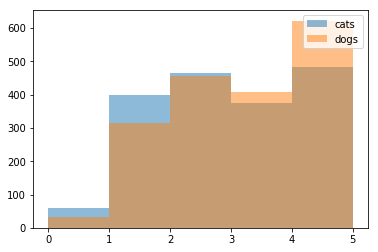

In [63]:
plt.hist(cats['AdoptionSpeed'], bins, alpha=0.5, label="cats")
plt.hist(dogs['AdoptionSpeed'], bins, alpha=0.5, label="dogs")
plt.legend(loc='upper right')
plt.show()